In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Слишком большой файл загрузим по кусочкам
df2 = pd.DataFrame({'normal_query': list(), 'datetime': list()})
chunksize = 1000000
for chunk in pd.read_csv('oscar', chunksize=chunksize, skiprows=0, delimiter='\t', encoding='utf_8', error_bad_lines=False):
    try:
        df2 = pd.concat([df2, chunk])
    except UnicodeDecodeError:
        continue

Найдем все запросы со словом "Оскар" и сохраним в отдельный датафрейм.

In [7]:
df2 = df2.dropna()
oscar = df2[df2['normal_query'].str.contains('оскар', case = False)]

In [14]:
oscar['datetime'] = pd.to_datetime(oscar['datetime']) 

/home/tahhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Разобьем получившийся датафрейм по времени на 3 части - до проведения Оскара, во время проведения и после проведения. 
В этом году Оскар прохододил в ночь с 24 на 25 февраля в Калифорнии, следовательно в России это уже было 25 февраля 2019.

In [17]:
# Запросы до проведения Оскара
oscar_before = oscar[oscar['datetime']  < datetime(2019, 2, 25)]
oscar_before['datetime'].min(), oscar_before['datetime'].max()

(Timestamp('2019-01-22 00:48:26'), Timestamp('2019-02-24 22:08:08'))

In [18]:
# Запросы после проведения Оскара
oscar_after = oscar[oscar['datetime']  > datetime(2019, 2, 26)]
oscar_after['datetime'].min(), oscar_after['datetime'].max()

(Timestamp('2019-02-26 00:19:36'), Timestamp('2019-02-28 21:22:59'))

In [19]:
# Запросы во время проведения Оскара
oscar_during = oscar[(oscar['datetime']  < datetime(2019, 2, 26)) & (oscar['datetime']  > datetime(2019, 2, 25))]
oscar_during['datetime'].min(), oscar_during['datetime'].max()

(Timestamp('2019-02-25 04:58:54'), Timestamp('2019-02-25 22:36:27'))

In [20]:
# Импортируем библиотеки
from sklearn.feature_extraction.text import CountVectorizer

## До проведения Оскара

### Подсчет количества токенов в словаре

In [26]:
texts_before = list(oscar_before['normal_query'].values)

In [124]:
# при помощи token_pattern удалим все предлоги (слова меньше 3 букв) и будем использовать слова, которые появляются чаще 2 раз
count_vectorizer_before = CountVectorizer(min_df=2, ngram_range=(1,3), token_pattern=r'(?u)\b\w\w\w+\b')
X_before = count_vectorizer_before.fit_transform(texts_before)

In [125]:
# Сделаем таблицу, где покажем чатстоту появления в запроск каждого токена
words_freq_before = pd.DataFrame({'tokens': count_vectorizer_before.get_feature_names(), 'frequency': X_before.toarray().sum(axis = 0)})
words_freq_before = words_freq_before.sort_values(by =  'frequency', ascending=False)
words_freq_before.head()

,tokens,frequency
183,оскар,400
10,2019,119
191,оскар 2019,114
160,номинанты,51
329,фильм,33


In [126]:
# Выберем только те запросы, которые встречаются больше 10 раз
more_then_10 = words_freq_before['frequency'] >10

Text(0.5, 1.0, 'Запросы до Оскара')

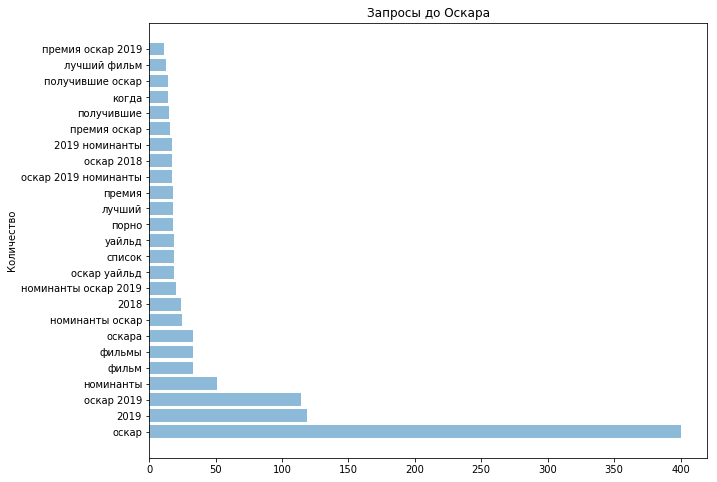

In [127]:
#vect.vocabulary_.values()
plt.figure(figsize=(10, 8))
objects = list(words_freq_before.loc[more_then_10, 'tokens'])
y_pos = np.arange(len(objects))
performance = list(words_freq_before.loc[more_then_10, 'frequency'])

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Количество')
plt.title('Запросы до Оскара')

### K-Means

In [128]:
from sklearn.cluster import KMeans

In [132]:
tfidf_kmeans = TfidfVectorizer(min_df=2, ngram_range=(1,3), token_pattern=r'(?u)\b\w\w\w+\b') 
X_before = tfidf_kmeans.fit_transform(texts_before)

In [133]:
# Посмотрим, сколько кластеров предложит Kmeans
inertias = []
ks = range(1, 10)

for k in ks:
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(X_before)
    inertias.append(model.inertia_)

Text(0.5, 1.0, 'Метод локтя для K-Means')

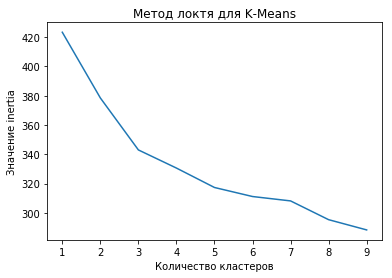

In [134]:
plt.plot(ks,inertias )
plt.ylabel('Значение inertia')
plt.xlabel('Количество кластеров')
plt.title('Метод локтя для K-Means')

**Вывод:** Kmeans указывает на 3 кластера.

In [137]:
# разобьем запросы на кластеры
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++')
model.fit(X_before)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [139]:

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_kmeans.get_feature_names()
for i in range(true_k):
    print("Кластер %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print()
    

Кластер 0:
 оскар 2019
 2019
 оскар
 номинанты
 номинанты оскар 2019
 номинанты оскар
 2019 номинанты
 оскар 2019 номинанты
 премия оскар 2019
 премия оскар

Кластер 1:
 оскар
 оскара
 фильм
 оскар уайльд
 уайльд
 фильмы
 2018
 оскар 2018
 порно
 скачать

Кластер 2:
 оскар
 что
 либо
 кучера личная
 кучера личная жизнь
 лауреат
 лауреат оскара
 лауреат оскара джефф
 лауреаты
 лауреаты оскара



**Вывод:** Метод KMeans выделяет запросы про номинантов на Оскар и известных людей с именем Оскар.

### NMF

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [175]:
# преобразовываем текст в матрицу взвешенных терминов-документов tf-idf
vectorizer = TfidfVectorizer(ngram_range=(1,3),token_pattern=r'(?u)\b\w\w\w+\b' )
X = vectorizer.fit_transform(texts_before)
 
idx_to_word = np.array(vectorizer.get_feature_names())

In [176]:
# применяем NMF
nmf = NMF(n_components=20, solver="mu")
W = nmf.fit_transform(X) 
H = nmf.components_

In [177]:
# print the topics 
for i, topic in enumerate(H): 
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-5:]]])))

Topic 1: 2019 победители,порно оскар 2019,оскар,2019,оскар 2019
Topic 2: хойя,оскар хойя,оскар хартманн,хартманн,оскар
Topic 3: номинанты оскар 2018,оскар,номинанты,номинанты оскар 2019,номинанты оскар
Topic 4: номинанты победители,2019 номинанты победители,номинанты,2019 номинанты,оскар 2019 номинанты
Topic 5: оскар 2019 дата,дата,премия оскар 2019,премия оскар,премия
Topic 6: все победители,2019 все,порно оскар 2019,порно,порно оскар
Topic 7: оскар уайльд излишества,уайльд излишества,читать,оскар уайльд,уайльд
Topic 8: фильмы оскар,фильмы,фильмы оскар 2018,2018,оскар 2018
Topic 9: фильмы получившие оскар,фильмы получившие,фильмы,получившие оскар,получившие
Topic 10: залесский,переславль залесский,оскар переславль залесский,переславль,оскар переславль
Topic 11: оскара лучший,оскара,лучший фильм,лучший,фильм
Topic 12: будет,когда будет,оскар 2019 когда,2019 когда,когда
Topic 13: кинотеатр,оскар кинотеатр,кинотеатр саратов,оскар кинотеатр саратов,саратов
Topic 14: номинации,номинации ос

**Вывод:** Метод NMF выделяет запросы:
1. о дате проведения Оскара;
2. про известных людей с именем Оскар;
3. номинантов и победителей премии Оскар;
4. запросы про фильмы и победителей прошлого года;
5. лучшие фильмы, получившие Оскар.

## Во время проведения Оскара

### Подсчет количества токенов в словаре

In [80]:
texts_during = list(oscar_during['normal_query'].values)

In [85]:
# при помощи token_pattern удалим все предлоги (слова меньше 3 букв) и будем использовать слова, которые появляются чаще 2 раз
count_vectorizer_during = CountVectorizer(min_df=2, ngram_range=(1,3), token_pattern=r'(?u)\b\w\w\w+\b')
X_during = count_vectorizer_during.fit_transform(texts_during)

In [86]:
# Сделаем таблицу, где покажем чатстоту появления в запроск каждого токена
words_freq_during = pd.DataFrame({'tokens': count_vectorizer_during.get_feature_names(), 'frequency': X_during.toarray().sum(axis = 0)})
words_freq_during = words_freq_during.sort_values(by =  'frequency', ascending=False)
words_freq_during.head()

,tokens,frequency
82,оскар,176
1,2019,144
84,оскар 2019,123
144,трансляция,17
108,победители,15


In [102]:
# Выберем только те запросы, которые встречаются больше 10 раз
more_then_3 = words_freq_during['frequency'] >3

Text(0.5, 1.0, 'Во время проведения Оскара')

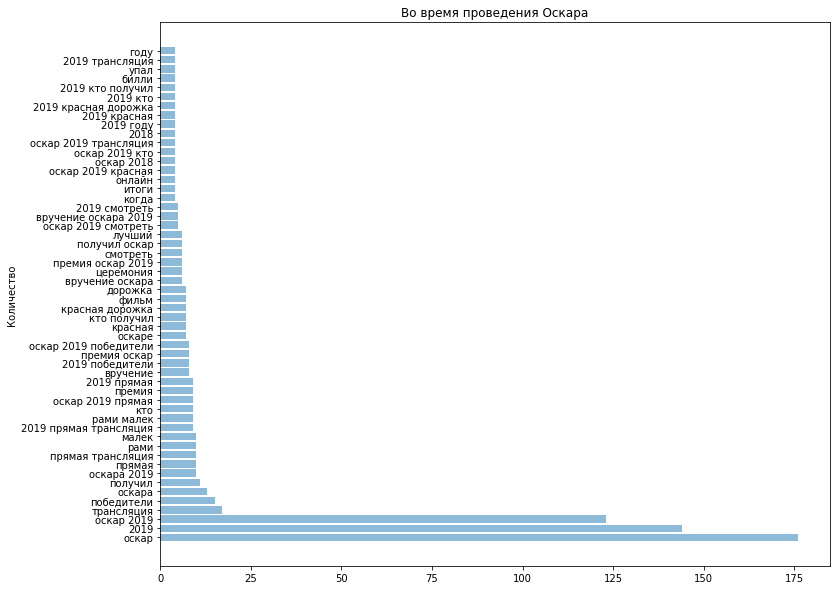

In [107]:
#vect.vocabulary_.values()
plt.figure(figsize=(12, 10))
objects = list(words_freq_during.loc[more_then_3, 'tokens'])
y_pos = np.arange(len(objects))
performance = list(words_freq_during.loc[more_then_3, 'frequency'])

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Количество')
plt.title('Во время проведения Оскара')

**Вывод:** простой подсчет количества токенов в словаре выделяет запросы:
        1. трансляция,
        2. победили (видимо, имеются в виду уже объявленные победели).

### K-Means

In [144]:
tfidf_during = TfidfVectorizer(min_df=2, ngram_range=(1,3), token_pattern=r'(?u)\b\w\w\w+\b') 
X_during_means = tfidf_during.fit_transform(texts_during)

In [145]:
# Посмотрим, сколько кластеров предложит Kmeans
inertias = []
ks = range(1, 10)

for k in ks:
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(X_during_means)
    inertias.append(model.inertia_)

Text(0.5, 1.0, 'Метод локтя для K-Means')

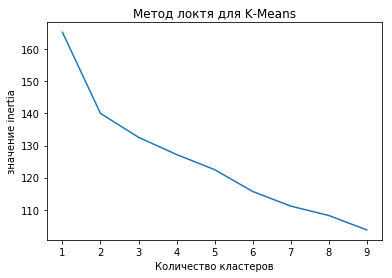

In [146]:
plt.plot(ks,inertias )
plt.ylabel('значение inertia')
plt.xlabel('Количество кластеров')
plt.title('Метод локтя для K-Means')

**Вывод:** K-Means выделяет 2 кластера. 

In [148]:
# разобьем запросы на кластеры
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++')
model.fit(X_during)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [149]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = terms = tfidf_during.get_feature_names()
for i in range(true_k):
    print("Кластер %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print()
    

Кластер 0:
 оскар
 2019
 оскар 2019
 трансляция
 победители
 прямая трансляция
 прямая
 2019 прямая трансляция
 2019 прямая
 кто

Кластер 1:
 оскар
 2019
 оскара
 оскара 2019
 малек
 рами
 рами малек
 вручение
 оскаре
 вручение оскара



**Вывод:** KMeans выделяет запросы:
        1. прямая трансляция,
        2. Рами Малека (он упал со сцены).

## NMF

In [156]:
# преобразовываем текст в матрицу взвешенных терминов-документов tf-idf
vectorizer_nmf_during = TfidfVectorizer(ngram_range=(1,3),token_pattern=r'(?u)\b\w\w\w+\b' )
X_nmf_during = vectorizer_nmf_during.fit_transform(texts_during)
 
idx_to_word = np.array(vectorizer_nmf_during.get_feature_names())

In [171]:
# применяем NMF
nmf = NMF(n_components=20, solver="mu")
W = nmf.fit_transform(X_nmf_during) 
H = nmf.components_

In [172]:
# print the topics 
for i, topic in enumerate(H): 
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-5:]]])))

Topic 1: 2019 фото,счастливый,негр платье,2015,номинации
Topic 2: 2019 победители,2019 победитеди,оливия,почему песни богемской,предверии
Topic 3: оскарбление это какая,оскар 2019 юрский,оскара стс,2019 платье,образы оскар 2019
Topic 4: оазис,2019 лучшая мужская,2019 лучший,кравченко оскар каримов,кто
Topic 5: оскар которые стоит,тодд фишер,книга номинации,оскар 2019 юрский,негр платье
Topic 6: 2019 кто получил,номинированные видео игры,кравиц оскаре,кравиц,дорожка 2019 оскар
Topic 7: рубашка подписями,ольга кравченко,получивший,полностью,получившие оскар
Topic 8: выдаинули,выступление леди гаги,выступление леди,оскар кучера фильмы,оскар лучший фильм
Topic 9: максимум,смотреть кинопоиск,лос анджелесе,премия оскар,премия
Topic 10: трансляция россии,тодд фишер,оливия колман оскар,2019 россии,речь
Topic 11: оскарбление это какая,оскар 2019 юрский,оскара стс,оскарам,оскарбление
Topic 12: русском полностью,рами малек получит,рубашка подписями 2019,2019 смотреть русском,ольга кравченко оскар

**Вывод:** Метод NMF выделяет запросы:
1. прямая трансляция;
2. объявленных победителей (кто уже получил Оскар);
3. красная дорожка (видимо, имеют виду зведы, которые пришли и фотографируются на крансой дорожке);
4. Рами Малек упал;
5. Песни Оскара - богемская рапсодия, песни Леди Гага

## После проведения Оскара

In [160]:
texts_after = list(oscar_after['normal_query'].values)

In [161]:
# при помощи token_pattern удалим все предлоги (слова меньше 3 букв) и будем использовать слова, которые появляются чаще 2 раз
count_vectorizer_after = CountVectorizer(min_df=2, ngram_range=(1,3), token_pattern=r'(?u)\b\w\w\w+\b')
X_after= count_vectorizer_after.fit_transform(texts_after)

In [162]:
# Сделаем таблицу, где покажем чатстоту появления в запроск каждого токена
words_freq_after= pd.DataFrame({'tokens': count_vectorizer_after.get_feature_names(), 'frequency': X_after.toarray().sum(axis = 0)})
words_freq_after = words_freq_after.sort_values(by =  'frequency', ascending=False)
words_freq_after.head()

,tokens,frequency
75,оскар,159
3,2019,121
77,оскар 2019,99
91,оскара,24
94,оскаре,15


In [163]:
# Выберем только те запросы, которые встречаются больше 10 раз
more_then_3 = words_freq_after['frequency'] >5

Text(0.5, 1.0, 'После проведения Оскара')

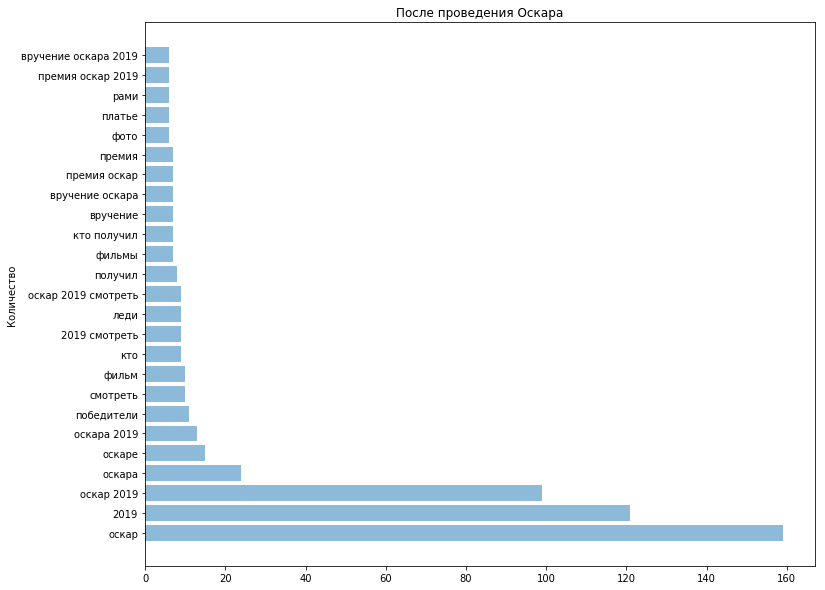

In [164]:
#vect.vocabulary_.values()
plt.figure(figsize=(12, 10))
objects = list(words_freq_after.loc[more_then_3, 'tokens'])
y_pos = np.arange(len(objects))
performance = list(words_freq_after.loc[more_then_3, 'frequency'])

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Количество')
plt.title('После проведения Оскара')

## NMF

In [165]:
# преобразовываем текст в матрицу взвешенных терминов-документов tf-idf
tfidf_nmf_after = TfidfVectorizer(ngram_range=(1,3),token_pattern=r'(?u)\b\w\w\w+\b' )
X_nmf_after = tfidf_nmf_after.fit_transform(texts_after)
 
idx_to_word = np.array(tfidf_nmf_after.get_feature_names())

In [169]:
# применяем NMF
nmf = NMF(n_components=20, solver="mu")
W = nmf.fit_transform(X_nmf_after) 
H = nmf.components_

In [170]:
# print the topics 
for i, topic in enumerate(H): 
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-5:]]])))

Topic 1: наряды,наряды оскар 2019,оскар,2019,оскар 2019
Topic 2: оскара,оскара 2019,вручение оскара 2019,вручение оскара,вручение
Topic 3: дата,оскар 2019 дата,премия оскар 2019,премия оскар,премия
Topic 4: оскар 2019 кто,2019 кто,кто,получил,кто получил
Topic 5: кинопоиск,2019 смотреть кинопоиск,смотреть,2019 смотреть,оскар 2019 смотреть
Topic 6: преми оскар,итоги,оскар трансляция,оскар итоги,оскар
Topic 7: оскар 2017,оскар 2017 победители,победители,2019 победители,оскар 2019 победители
Topic 8: 2019 номинанты победители,номинанты победители,номинанты,2019 номинанты,оскар 2019 номинанты
Topic 9: фото ковровой дорожки,ковровой дорожки,оскар 2019 фото,2019 фото,фото
Topic 10: леди гага оскаре,оскаре,леди гага,гага,леди
Topic 11: оскара,оскара 2019,результаты оскара,результаты оскара 2019,результаты
Topic 12: джеймс,макэвой,джеймс макэвой оскар,макэвой оскар 2019,макэвой оскар
Topic 13: розовый,розовый смокинг оскаре,розовый смокинг,смокинг оскаре,оскаре
Topic 14: лучшая мужская роль,лу

**Вывод:** Метод NMF выделяет запросы:
1. кто получил премию;
2. победителей Оскара 2019;
3. фото с ковровой дорожки;
4. каких-то отдельных звезд, отличившихся на Оскаре.
5. Наряды 